In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch

from CASBI.utils.create_dataframe import rescale
from CASBI.sbi.conf_yaml import generate_data_yaml, generate_training_yaml
from CASBI.sbi.gen_halo import  gen_halo_Nsubhalos, gen_halo
from CASBI.sbi.inference import run_inference, load_posterior, infer_observation, evaluate_posterior, calibrarion

In [2]:
! cd ../../../../data/vgiusepp/complete_inference/; tree

.
├── N_subhalos_data
│   ├── N_subhalos.npy
│   ├── N_subhalos_0.npy
│   ├── N_subhalos_test.npy
│   ├── galaxy_0.npy
│   ├── parameters_0.npy
│   ├── x.npy
│   ├── x_0.npy
│   └── x_test.npy
├── N_subhalos_data.yaml
├── N_subhalos_training.yaml
├── data
├── data.yaml
├── inference_N_subhalos.npy
├── inference_galaxy.npy
├── inference_parameters.npy
├── inference_theta.npy
├── inference_x.npy
└── training.yaml

2 directories, 17 files


In [3]:
#generate the yaml file for the two inference part 
inference_dir = "../../../../data/vgiusepp/complete_inference/" #where all the data and yaml file will be stored

yaml_N_subhalos_data_path = os.path.join(inference_dir, "N_subhalos_data.yaml")
yamL_N_subhalos_training_path = os.path.join(inference_dir, "N_subhalos_training.yaml")

yaml_data_path = os.path.join(inference_dir, "data.yaml")
yaml_training_path = os.path.join(inference_dir, "training.yaml")


In [4]:
! cd ../../../../data/vgiusepp/complete_inference/; cat N_subhalos_data.yaml

in_dir: ../../../../data/vgiusepp/complete_inference/N_subhalos_data/
theta_file: N_subhalos.npy
thetafid_file: N_subhalos_0.npy
x_file: x.npy
xobs_file: x_0.npy


In [7]:
#Number of subhalos inference
generate_data_yaml(filepath=yaml_N_subhalos_data_path, 
                   in_dir=os.path.join(inference_dir, 'N_subhalos_data/'), #where the data are stored
                   theta_file='N_subhalos.npy',
                   thetafid_file='N_subhalos_0.npy')
generate_training_yaml(filepath=yamL_N_subhalos_training_path,)


#Subhalos properties inference
generate_data_yaml(filepath=yaml_data_path, 
                   in_dir=os.path.join(inference_dir, 'data/')) #where the data are stored
generate_training_yaml(filepath=yaml_training_path,)

In [4]:
#loading and rescaling the data
data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameters=True, inverse=True) 
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)


min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])
#unseen galaxies to do infernce on when the whole pipeline is ready
inference_N_subhalos = 2
inference_galaxy = data['Galaxy_name'].drop_duplicates().sample(inference_N_subhalos)
inference_parameters =  data[data['Galaxy_name'].isin(inference_galaxy)].drop(['feh', 'ofe', 'Galaxy_name'], axis=1).drop_duplicates().values.T
sorted_index = np.argsort(inference_parameters[0], )[::-1] #orders the parameters in descending order of star mass
inference_parameters = (inference_parameters[:,sorted_index]).reshape(-1)
inferernce_galaxy_data = data[data['Galaxy_name'].isin(inference_galaxy)].values
histogram_galaxy, _, _ = np.histogram2d(inferernce_galaxy_data[:, 0], inferernce_galaxy_data[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
infererence_sim_data =  np.expand_dims(np.log10(histogram_galaxy + 1e-6 +1), axis=0)

np.save(os.path.join(inference_dir, 'inference_N_subhalos.npy'), np.array(inference_N_subhalos).reshape(1, 1))
np.save(os.path.join(inference_dir, 'inference_theta.npy'), inference_parameters)
np.save(os.path.join(inference_dir, 'inference_x.npy'), infererence_sim_data)
np.save(os.path.join(inference_dir, 'inference_galaxy.npy'), inference_galaxy.values)

#remove the galaxies
data = data[~data['Galaxy_name'].isin(inference_galaxy)]

In [13]:
#generate halos for the training of the N_subhalos inference 
_ = gen_halo_Nsubhalos(data=data,
                       output_dir=os.path.join(inference_dir,'N_subhalos_data' ),
                       n_test=10,
                       n_train=100,)

finish prepare the data


In [5]:
#train the posterior
# run_inference(yamL_N_subhalos_training_path, yaml_N_subhalos_data_path)

#load the posterior from pkl file 
posterior = load_posterior('./ltu_ili_test/n_subhalo_finder/toy_NPE_posterior_best.pkl')

Drawing 2227 posterior samples:   0%|          | 0/2227 [00:00<?, ?it/s]

Drawing 2067 posterior samples:   0%|          | 0/2067 [00:00<?, ?it/s]

Drawing 3297 posterior samples:   0%|          | 0/3297 [00:00<?, ?it/s]

Drawing 2409 posterior samples:   0%|          | 0/2409 [00:00<?, ?it/s]

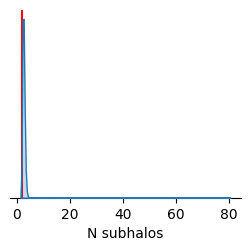

In [6]:
#evaluate posterior
fig = evaluate_posterior(posterior, observation_path=os.path.join(inference_dir, 'inference_x.npy'), parameter_path=os.path.join(inference_dir, 'inference_N_subhalos.npy'), labels=['N subhalos'], n_samples=10000)

In [7]:
samples = infer_observation(posterior, observation_path=os.path.join(inference_dir, 'inference_x.npy'), n_samples=10_000)
print(r'$$<N_subhalos> \pm \sigma_{N_{subhalos}} $$:', samples.mean().cpu(), '+-', samples.std().cpu())
print('original value:', np.load(os.path.join(inference_dir, 'inference_N_subhalos.npy')))

Drawing 2167 posterior samples:   0%|          | 0/2167 [00:00<?, ?it/s]

Drawing 2086 posterior samples:   0%|          | 0/2086 [00:00<?, ?it/s]

Drawing 3305 posterior samples:   0%|          | 0/3305 [00:00<?, ?it/s]

Drawing 2442 posterior samples:   0%|          | 0/2442 [00:00<?, ?it/s]

$$<N_subhalos> \pm \sigma_{N_{subhalos}} $$: tensor(2.5115) +- tensor(0.9204)
original value: [[2]]


  0%|          | 0/979 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:10<00:00,  9.14it/s]


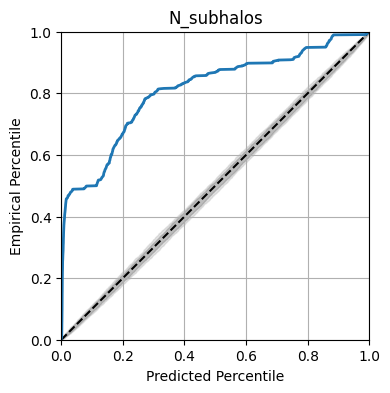

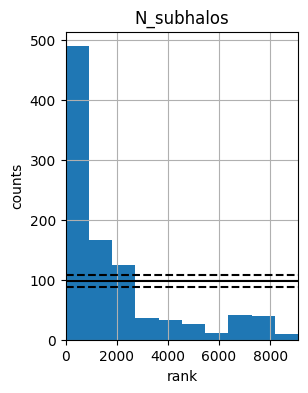

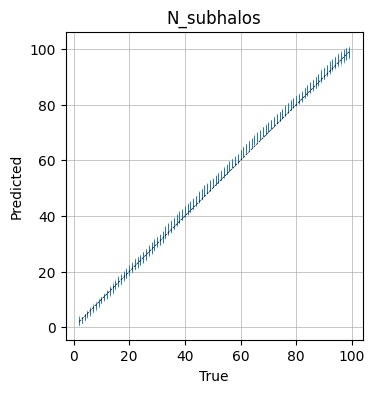

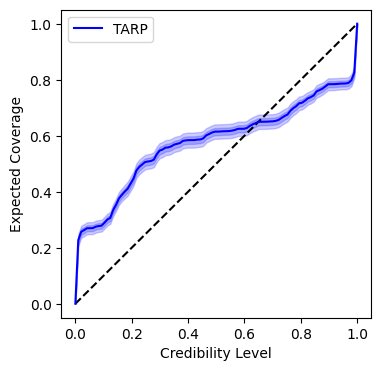

In [18]:
fig = calibrarion(posterior=posterior, observation_test_path=os.path.join(inference_dir, 'N_subhalos_data/x_test.npy'), parameter_test_path=os.path.join(inference_dir, 'N_subhalos_data/N_subhalos_test.npy'), n_samples=10_000, labels=['N_subhalos'])

In [8]:
_ = gen_halo(data=data, output_dir=os.path.join(inference_dir,'data' ), 
             training_yaml=yaml_training_path, 
             n_test=10, n_train=100,N_subhalos=int(samples.mean()))


running gen halo
write the right prior in the training.yaml file
finish prepare the data


In [10]:
data.head()

,feh,ofe,star_log10mass,dm_log10mass,infall_time,Galaxy_name
0,-2.248718,0.134359,6.666085,9.752208,1.991197,g1.05e11.00096
1,-2.751398,-0.044641,6.666085,9.752208,1.991197,g1.05e11.00096
2,-3.574646,0.396199,6.666085,9.752208,1.991197,g1.05e11.00096
3,-1.997361,-0.092419,6.666085,9.752208,1.991197,g1.05e11.00096
4,-3.564119,0.068897,6.666085,9.752208,1.991197,g1.05e11.00096
